In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from glob import glob
from keras import Input, Model, layers, optimizers, Sequential
import os
import math
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
from PIL import Image, ImageDraw

c:\Users\User\miniconda3\envs\paper\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 데이터 준비

In [2]:
# imgaug 사용 시
# def build_augmentation(is_train=True):
#     if is_train:
#         return iaa.Sequential([
#             iaa.Fliplr(0.5),  # 50%의 확률로 좌우 대칭
#         iaa.Sometimes(
#             p=0.5,
#             then_list=iaa.CropAndPad(
#                 percent=(-0.3, 0.2),  # 크롭 비율 범위 지정
#                 pad_mode=ia.ALL,  # 모든 방향으로 패딩
#                 pad_cval=(0, 255)  # 패딩 값 범위 지정
#         )
#     ),
#     iaa.Resize({"width": 224, "height": 224})  # 입력 이미지를 224x224로 resize
# ])
        
#     else:
#         return iaa.Sequential([
#             iaa.Resize({"width": 224, "height": 224})
#         ])

In [2]:
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(320, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

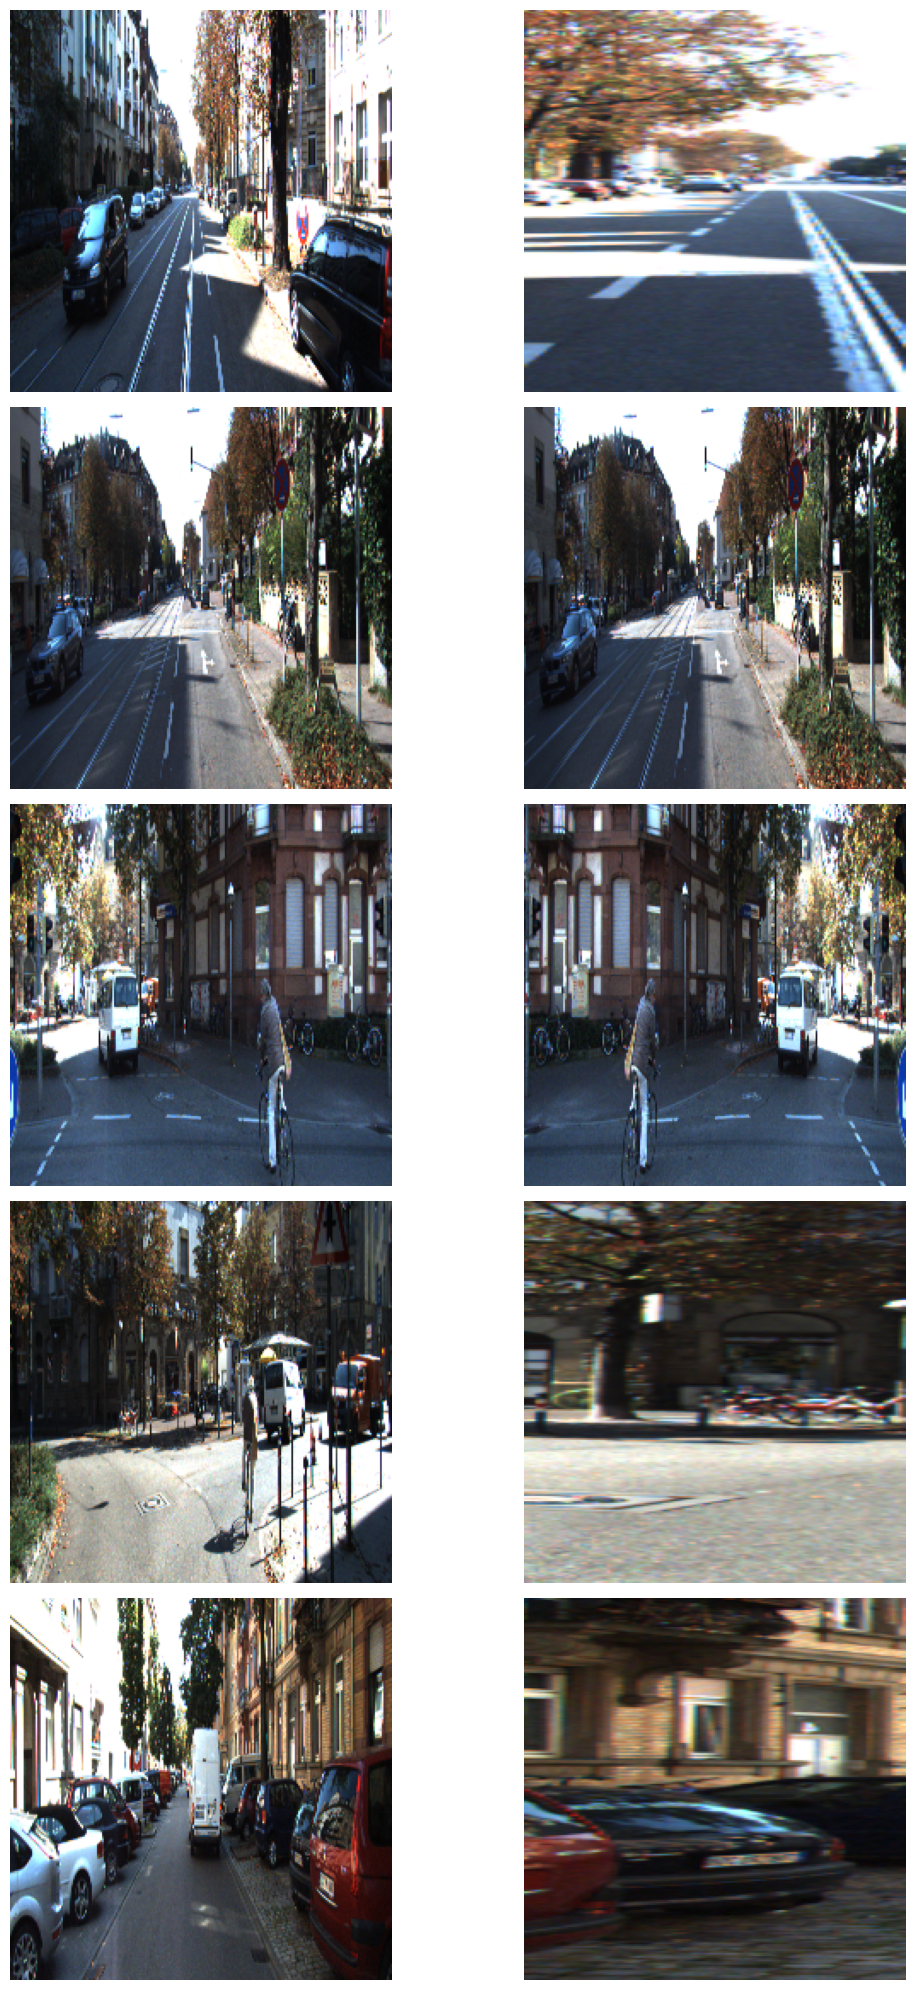

In [3]:
dir_path = './data/semantic_segmentation/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized['image'])  # 왼쪽이 원본이미지
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed['image'])  # 오른쪽이 augment된 이미지
    plt.axis('off')
plt.tight_layout()
plt.show()

데이터셋 구성용 data generator 작성

In [18]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=64,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    batch_data = self.data[
        index * self.batch_size: (index + 1) * self.batch_size
    ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])

    for i, data in enumerate(batch_data):
        input_img_path, output_path = data
        _input = imread(input_img_path)
        _output = imread(output_path)
        _output = (_output == 7).astype(np.uint8) * 1
        data = {
            "image": _input,
            "mask": _output,
        }
        augmented = self.augmentation(**data)
        inputs[i] = augmented["image"] / 255
        outputs[i] = augmented["mask"]

    return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 모델 작성

## U-Net

In [7]:
class UNet(Model):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Contracting Path
        self.conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv1_2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv2_2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv3_2 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv4_2 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.dropout4 = layers.Dropout(0.5)
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv5_2 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        
        # Expanding Path
        self.dropout5 = layers.Dropout(0.5)
        self.up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat6 = layers.Concatenate(axis=3)
        self.conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv6_2 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        
        self.up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat7 = layers.Concatenate(axis=3)
        self.conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv7_2 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        
        self.up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat8 = layers.Concatenate(axis=3)
        self.conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv8_2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        
        self.up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat9 = layers.Concatenate(axis=3)
        self.conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv9_2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv9_3 = layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv10 = layers.Conv2D(1, 1, activation='sigmoid')
    
    def call(self, inputs):
        # Contracting Path
        conv1 = self.conv1(inputs)
        conv1 = self.conv1_2(conv1)
        pool1 = self.pool1(conv1)
        
        conv2 = self.conv2(pool1)
        conv2 = self.conv2_2(conv2)
        pool2 = self.pool2(conv2)
        
        conv3 = self.conv3(pool2)
        conv3 = self.conv3_2(conv3)
        pool3 = self.pool3(conv3)
        
        conv4 = self.conv4(pool3)
        conv4 = self.conv4_2(conv4)
        drop4 = self.dropout4(conv4)
        pool4 = self.pool4(drop4)
        
        conv5 = self.conv5(pool4)
        conv5 = self.conv5_2(conv5)
        
        # Expanding Path
        drop5 = self.dropout5(conv5)
        up6 = self.up6(drop5)
        merge6 = self.concat6([drop4, up6])
        conv6 = self.conv6(merge6)
        conv6 = self.conv6_2(conv6)
        
        up7 = self.up7(conv6)
        merge7 = self.concat7([conv3, up7])
        conv7 = self.conv7(merge7)
        conv7 = self.conv7_2(conv7)
        
        up8 = self.up8(conv7)
        merge8 = self.concat8([conv2, up8])
        conv8 = self.conv8(merge8)
        conv8 = self.conv8_2(conv8)
        
        up9 = self.up9(conv8)
        merge9 = self.concat9([conv1, up9])
        conv9 = self.conv9(merge9)
        conv9 = self.conv9_2(conv9)
        conv9 = self.conv9_3(conv9)
        conv10 = self.conv10(conv9)
        
        return conv10

## U-Net with BN

In [19]:
class UNet_bn(Model):
    def __init__(self):
        super(UNet_bn, self).__init__()
        
        # Contracting Path
        self.conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv1_2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv2_2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv3_2 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv4_2 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.dropout4 = layers.Dropout(0.5)
        self.bn4 = layers.BatchNormalization()
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv5_2 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        
        # Expanding Path
        self.dropout5 = layers.Dropout(0.5)
        self.up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat6 = layers.Concatenate(axis=3)
        self.conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv6_2 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.bn6 = layers.BatchNormalization()
        
        self.up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat7 = layers.Concatenate(axis=3)
        self.conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv7_2 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.bn7 = layers.BatchNormalization()
        
        self.up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat8 = layers.Concatenate(axis=3)
        self.conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv8_2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.bn8 = layers.BatchNormalization()
        
        self.up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), kernel_initializer='he_normal')
        self.concat9 = layers.Concatenate(axis=3)
        self.conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv9_2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv9_3 = layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv10 = layers.Conv2D(1, 1, activation='sigmoid')
    
    def call(self, inputs):
        # Contracting Path
        conv1 = self.conv1(inputs)
        conv1 = self.conv1_2(conv1)
        conv1 = self.bn1(conv1)
        pool1 = self.pool1(conv1)
        
        conv2 = self.conv2(pool1)
        conv2 = self.conv2_2(conv2)
        conv2 = self.bn2(conv2)
        pool2 = self.pool2(conv2)
        
        conv3 = self.conv3(pool2)
        conv3 = self.conv3_2(conv3)
        conv3 = self.bn3(conv3)
        pool3 = self.pool3(conv3)
        
        conv4 = self.conv4(pool3)
        conv4 = self.conv4_2(conv4)
        conv4 = self.dropout4(conv4)
        conv4 = self.bn4(conv4)
        pool4 = self.pool4(conv4)
        
        conv5 = self.conv5(pool4)
        conv5 = self.conv5_2(conv5)
        
        # Expanding Path
        drop5 = self.dropout5(conv5)
        up6 = self.up6(drop5)
        merge6 = self.concat6([conv4, up6])
        conv6 = self.conv6(merge6)
        conv6 = self.conv6_2(conv6)
        conv6 = self.bn6(conv6)
        
        up7 = self.up7(conv6)
        merge7 = self.concat7([conv3, up7])
        conv7 = self.conv7(merge7)
        conv7 = self.conv7_2(conv7)
        conv7 = self.bn7(conv7)
        
        up8 = self.up8(conv7)
        merge8 = self.concat8([conv2, up8])
        conv8 = self.conv8(merge8)
        conv8 = self.conv8_2(conv8)
        conv8 = self.bn8(conv8)
        
        up9 = self.up9(conv8)
        merge9 = self.concat9([conv1, up9])
        conv9 = self.conv9(merge9)
        conv9 = self.conv9_2(conv9)
        conv9 = self.conv9_3(conv9)
        conv10 = self.conv10(conv9)
        
        return conv10


## U-Net ++ V1
[이거나 구현해보자](https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py)

In [16]:
class UNetPlusPlus(Model):
    def __init__(self):
        super(UNetPlusPlus, self).__init__()

    def conv_block(self, inputs, filters):
        conv1 = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
        conv2 = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
        return conv2

    def up_conv_block(self, inputs, skip, filters):
        up = layers.Conv2DTranspose(filters, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
        merge = layers.Add()([up, skip])
        conv = self.conv_block(merge, filters)
        return conv

    def call(self, inputs):
        # Contracting path (Backbone)
        conv1 = self.conv_block(inputs, 64)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = self.conv_block(pool1, 128)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = self.conv_block(pool2, 256)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = self.conv_block(pool3, 512)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = self.conv_block(pool4, 1024)

        # Expansive path
        up4 = self.up_conv_block(conv5, conv4, 512)
        up3 = self.up_conv_block(up4, conv3, 256)
        up2 = self.up_conv_block(up3, conv2, 128)
        up1 = self.up_conv_block(up2, conv1, 64)

        conv6 = layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
        conv7 = layers.Conv2D(1, 1, activation='sigmoid')(conv6)

        return conv7

## U-Net ++ V2(나중에..)

In [ ]:
# class UNet_v2(Model):
#     def __init__(self, *args, **kwargs):
#         super(UNet_v2, self).__init__(*args, **kwargs)

# 모델 학습

## UNet

Epoch 1/300
3/3 [==============================] - 2s 648ms/step - loss: 0.6925 - val_loss: 0.6906
Epoch 2/300
3/3 [==============================] - 2s 541ms/step - loss: 0.6882 - val_loss: 0.6863
Epoch 3/300
3/3 [==============================] - 2s 542ms/step - loss: 0.6851 - val_loss: 0.6752
Epoch 4/300
3/3 [==============================] - 2s 542ms/step - loss: 0.6622 - val_loss: 0.6134
Epoch 5/300
3/3 [==============================] - 2s 547ms/step - loss: 0.4581 - val_loss: 0.1962
Epoch 6/300
3/3 [==============================] - 2s 542ms/step - loss: 0.0545 - val_loss: 0.0130
Epoch 7/300
3/3 [==============================] - 2s 539ms/step - loss: 0.0099 - val_loss: 0.0087
Epoch 8/300
3/3 [==============================] - 2s 572ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 9/300
3/3 [==============================] - 2s 539ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 10/300
3/3 [==============================] - 2s 536ms/step - loss: 0.0083 - val_loss: 0.0091
Epoch 11/

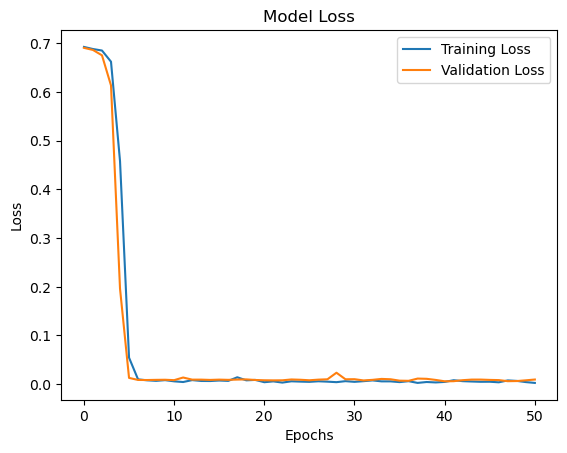

In [23]:
model_path = './data/semantic_segmentation/models/UNet/'

model = UNet()
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     callbacks=[es],
     epochs=300,
 )

# 모델 저장
model.save(model_path)

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## UNet w/ BN

In [20]:
model_path = './data/semantic_segmentation/models/UNet_BN/'

model = UNet_bn()
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     callbacks=[es],
     epochs=300,
 )

# 모델 저장
model.save(model_path)

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/300


ResourceExhaustedError:  OOM when allocating tensor with shape[64,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/u_net_bn_2/conv2d_98/Conv2D/Conv2DBackpropInput
 (defined at c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13330]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/u_net_bn_2/conv2d_98/Conv2D/Conv2DBackpropInput:
In[0] gradient_tape/u_net_bn_2/conv2d_98/Conv2D/ShapeN:	
In[1] u_net_bn_2/conv2d_98/Conv2D/ReadVariableOp (defined at c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\layers\convolutional.py:231)	
In[2] gradient_tape/u_net_bn_2/conv2d_98/ReluGrad:

Operation defined at: (most recent call last)
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
>>>     result = runner(coro)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\User\AppData\Local\Temp\ipykernel_27832\209289351.py", line 6, in <module>
>>>     history = model.fit(
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

## UNet ++

In [21]:
model_path = './data/semantic_segmentation/models/UNet++v1/'

model = UNetPlusPlus()
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

# 모델 저장
model.save(model_path)

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100


ValueError: in user code:

    File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "u_net_plus_plus_3" (type UNetPlusPlus).
    
    in user code:
    
        File "C:\Users\User\AppData\Local\Temp\ipykernel_27832\55676813.py", line 18, in call  *
            conv1 = self.conv_block(inputs, 64)
        File "C:\Users\User\AppData\Local\Temp\ipykernel_27832\55676813.py", line 6, in conv_block  *
            conv1 = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
        File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\layers\convolutional.py", line 373, in _get_input_channel
            raise ValueError('The channel dimension of the inputs should be defined. '
    
        ValueError: The channel dimension of the inputs should be defined. The input_shape received is (None, None, None, None), where axis -1 (0-based) is the channel dimension, which found to be `None`.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, None, None, None), dtype=float32)


## UNet ++ v2

In [ ]:
# model_path = './data/semantic_segmentation/models/UNet++v2/'

# model = UNet_v2()
# model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
# history = model.fit(
#      train_generator,
#      validation_data=test_generator,
#      steps_per_epoch=len(train_generator),
#      epochs=100,
#  )

# # 모델 저장
# model.save(model_path)

# # 학습 과정 시각화
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# 모델 평가

In [13]:
model_path = './data/semantic_segmentation/models/UNet/'
model = tf.keras.models.load_model(model_path)

In [36]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.

     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

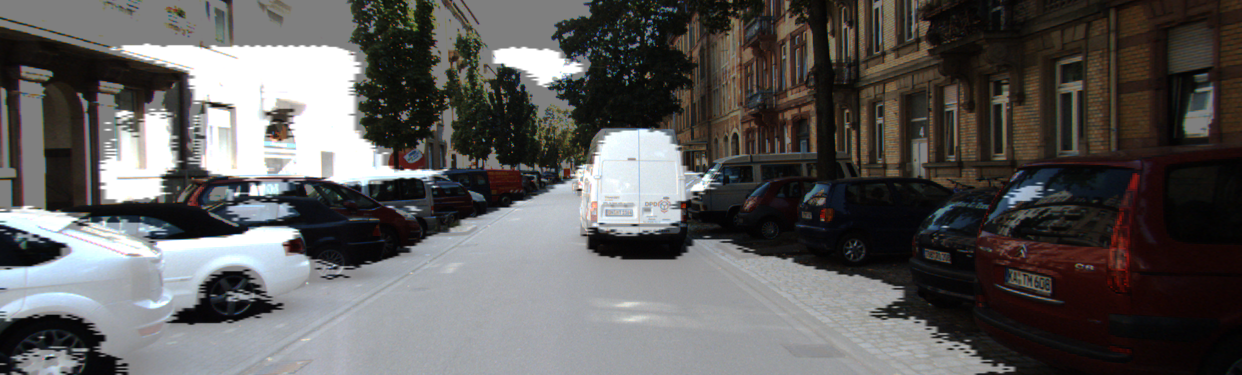

In [37]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4   # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

도로를 잘 잡았지만 주변 일부자동차들(왼쪽), 앞의 밴?, 왼족 건물 일부, 하늘 (일부 중앙 위)를 잘못 잡아냈다.

In [38]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [39]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    #output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

## Trained UNet

In [29]:
model_path = './data/semantic_segmentation/models/UNet/'
model = tf.keras.models.load_model(model_path)

In [33]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
result = []
for i in range(10):
    output, prediction, target = get_output(
        model, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    result.append(calculate_iou_score(target, prediction))
print('10개 이미지 평균 IOU: ', np.mean(result))

IoU : 0.558118
IoU : 0.632882
IoU : 0.441132
IoU : 0.581255
IoU : 0.370627
IoU : 0.379274
IoU : 0.236428
IoU : 0.550516
IoU : 0.605934
IoU : 0.622255
10개 이미지 평균 IOU:  0.4978422315154269


## UNet(trained with BatchNormalizaiton)

In [ ]:
model_path = './data/semantic_segmentation/models/UNet_BN/'
model2 = tf.keras.models.load_model(model_path)

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
result = []
for i in range(10):
    output, prediction, target = get_output(
        model2, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    result.append(calculate_iou_score(target, prediction))
print('10개 이미지 평균 IOU: ', np.mean(result))

## UNet(pretrained)
LMS상에 있던 가중치파일

In [26]:
model_path = './data/semantic_segmentation/training/seg_model_unet.h5'
model3 = tf.keras.models.load_model(model_path)

In [34]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
result = []
for i in range(10):
    output, prediction, target = get_output(
        model3, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    result.append(calculate_iou_score(target, prediction))
print('10개 이미지 평균 IOU: ', np.mean(result))

IoU : 0.169052
IoU : 0.419672
IoU : 0.584009
IoU : 0.571212
IoU : 0.560356
IoU : 0.647032
IoU : 0.096658
IoU : 0.681927
IoU : 0.382736
IoU : 0.417703
10개 이미지 평균 IOU:  0.45303560386789643


## UNet ++ v1

In [ ]:
model_path = './data/semantic_segmentation/models/UNetv1'
model4 = tf.keras.models.load_model(model_path)

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
result = []
for i in range(10):
    output, prediction, target = get_output(
        model4, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    result.append(calculate_iou_score(target, prediction))
print('10개 이미지 평균 IOU: ', np.mean(result))

## UNet ++ v2(추후)

In [ ]:
# model_path = './data/semantic_segmentation/models/UNetv2'
# model4 = tf.keras.models.load_model(model_path)

In [ ]:
# # 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
# result = []
# for i in range(10):
#     output, prediction, target = get_output(
#         model4, 
#         test_preproc,
#         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
#         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
#         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
#     )

#     result.append(calculate_iou_score(target, prediction))
# print('10개 이미지 평균 IOU: ', np.mean(result))

모델별 iou 비교 해야함
unet,v1,v2, 저장된